# Advanced SQL [2] - Advanced Data Engineering Pipeline

In [ ]:
# Import necessary libraries
import os
import zipfile
import sqlite3
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import hashlib
import random
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths for the dataset
zip_file_path = 'brain_tumor_mri.zip'  # Update with your uploaded file path
extraction_path = ''     # Extraction path

Using device: cuda


In [ ]:
# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Print the directory structure to verify the contents
for root, dirs, files in os.walk('brain_tumor_mri/'):
    print(root, "contains", len(files), "files and", len(dirs), "directories.")

# Define paths for training and testing directories based on the extracted structure
train_dir = os.path.join('brain_tumor_mri/', 'training')
test_dir = os.path.join('brain_tumor_mri/', 'testing')


brain_tumor_mri/ contains 0 files and 2 directories.
brain_tumor_mri/testing contains 1 files and 4 directories.
brain_tumor_mri/testing/meningioma contains 306 files and 0 directories.
brain_tumor_mri/testing/glioma contains 300 files and 0 directories.
brain_tumor_mri/testing/pituitary contains 300 files and 0 directories.
brain_tumor_mri/testing/notumor contains 405 files and 0 directories.
brain_tumor_mri/training contains 0 files and 4 directories.
brain_tumor_mri/training/meningioma contains 1339 files and 0 directories.
brain_tumor_mri/training/glioma contains 1321 files and 0 directories.
brain_tumor_mri/training/pituitary contains 1457 files and 0 directories.
brain_tumor_mri/training/notumor contains 1595 files and 0 directories.


In [ ]:
# Function to calculate hash for an image
def calculate_image_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Connect to SQLite database
conn = sqlite3.connect('brain_tumor_mri.db')
c = conn.cursor()

# Drop the existing table if it exists to avoid duplicate column issues
c.execute('DROP TABLE IF EXISTS mri_data')

# Create a table to store metadata about the images, including a hash column
c.execute('''
CREATE TABLE mri_data (
    image_path TEXT PRIMARY KEY,
    label TEXT,
    split TEXT,
    image_hash TEXT
)
''')

# Function to add images from a directory to the SQLite database with hashes
def add_images_to_db(directory, split):
    for label in os.listdir(directory):  # Each subfolder is considered a label
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            for img_file in os.listdir(label_path):
                if img_file.endswith('.jpg'):  # Only process .jpg files
                    img_path = os.path.join(label_path, img_file)
                    # Calculate the image hash
                    img_hash = calculate_image_hash(img_path)
                    # Insert image path, label, split (train/test), and hash into the database
                    c.execute("INSERT OR IGNORE INTO mri_data (image_path, label, split, image_hash) VALUES (?, ?, ?, ?)",
                              (img_path, label, split, img_hash))

# Add training and testing images to the database
add_images_to_db(train_dir, 'train')
add_images_to_db(test_dir, 'test')

# Commit the changes to the database
conn.commit()

# Count the total number of images
total_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data", conn)
print("Total number of images in the dataset:")
display(total_counts_df)


# Count the number of images per label
label_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data GROUP BY label", conn)
print("Number of images per label:")
display(label_counts_df)

# Count the number of images in each split (train/test)
split_counts_df = pd.read_sql_query("SELECT split, COUNT(*) as count FROM mri_data GROUP BY split", conn)
print("Number of images in each split (train/test):")
display(split_counts_df)


# Verify initial data in the database by fetching the first few rows
initial_data_df = pd.read_sql_query("SELECT * FROM mri_data LIMIT 5", conn)
print("Initial data in the database with hashes:")
display(initial_data_df)

# Display hash distribution to verify initial counts
initial_hash_counts_df = pd.read_sql_query("SELECT image_hash, COUNT(*) as count FROM mri_data GROUP BY image_hash HAVING count > 1", conn)
print("Duplicate hash values (indicating duplicate images):")
display(initial_hash_counts_df)


Total number of images in the dataset:


label  count
0  meningioma   7023

Number of images per label:


label  count
0      glioma   1621
1  meningioma   1645
2     notumor   2000
3   pituitary   1757

Number of images in each split (train/test):


split  count
0   test   1311
1  train   5712

Initial data in the database with hashes:


image_path       label  split  \
0  brain_tumor_mri/training/meningioma/Tr-me_0358...  meningioma  train   
1  brain_tumor_mri/training/meningioma/Tr-me_0781...  meningioma  train   
2  brain_tumor_mri/training/meningioma/Tr-me_1261...  meningioma  train   
3  brain_tumor_mri/training/meningioma/Tr-me_0195...  meningioma  train   
4  brain_tumor_mri/training/meningioma/Tr-me_0495...  meningioma  train   

                         image_hash  
0  fe7b3a2c74be0c970c4a514d7f6bee5f  
1  088a4a94bad5f87e30e33533fbaa931f  
2  0ee298d4c70ea7cab905dad49f60b5f6  
3  deda53fba5fff5371017b18f1f85b360  
4  d4aed66a7a298f3570c233d2814cc584

Duplicate hash values (indicating duplicate images):


image_hash  count
0    04ad12436c5b59dac34ff27b48e8dd9a      3
1    05c3caea567ffd77caf79c12654b87e5      3
2    05fe39a899414d2dab6cad25c301b32c      2
3    06c3e21e888012e7845da47b26b742e8      2
4    0abe34033d22367d0fe55445050a6f7e      2
..                                ...    ...
189  f4b4f54022e5d07d1cfecf6868492299      3
190  f6a666f3aad6223c98e59c677b06310c      2
191  fc6ff0af19a89f3e2c2c4b1d7f5b9dc6      5
192  fdea69d8f1eaf6ad0933a4e4ba3cc4f6      2
193  fe2231f523d6d1cabd4670f11b829773      2

[194 rows x 2 columns]

In [ ]:
# Remove duplicate entries by keeping only unique image hashes
c.execute('''
DELETE FROM mri_data
WHERE rowid NOT IN (
    SELECT MIN(rowid)
    FROM mri_data
    GROUP BY image_hash
)
''')
conn.commit()

# Fetch and display data to verify duplicate removal based on image content
dedup_data_df = pd.read_sql_query("SELECT * FROM mri_data LIMIT 5", conn)
print("Data after removing duplicates based on image hash:")
display(dedup_data_df)

# Display hash distribution again to ensure duplicates were removed
dedup_hash_counts_df = pd.read_sql_query("SELECT image_hash, COUNT(*) as count FROM mri_data GROUP BY image_hash HAVING count > 1", conn)
print("Duplicate hash values after removal (should be empty):")
display(dedup_hash_counts_df)


Data after removing duplicates based on image hash:


image_path       label  split  \
0  brain_tumor_mri/training/meningioma/Tr-me_0358...  meningioma  train   
1  brain_tumor_mri/training/meningioma/Tr-me_0781...  meningioma  train   
2  brain_tumor_mri/training/meningioma/Tr-me_1261...  meningioma  train   
3  brain_tumor_mri/training/meningioma/Tr-me_0195...  meningioma  train   
4  brain_tumor_mri/training/meningioma/Tr-me_0495...  meningioma  train   

                         image_hash  
0  fe7b3a2c74be0c970c4a514d7f6bee5f  
1  088a4a94bad5f87e30e33533fbaa931f  
2  0ee298d4c70ea7cab905dad49f60b5f6  
3  deda53fba5fff5371017b18f1f85b360  
4  d4aed66a7a298f3570c233d2814cc584

Duplicate hash values after removal (should be empty):


Empty DataFrame
Columns: [image_hash, count]
Index: []

In [ ]:
# Add a column for the length of each image file name
try:
    c.execute('ALTER TABLE mri_data ADD COLUMN file_name_length INTEGER')
except sqlite3.OperationalError:
    print("Column 'file_name_length' already exists.")  # Avoid duplicate column error if re-run

# Update file_name_length column based on the length of the file name
c.execute('''
UPDATE mri_data
SET file_name_length = LENGTH(image_path) - LENGTH(REPLACE(image_path, '/', '')) - LENGTH(SUBSTR(image_path, 0, INSTR(image_path, '/')))
''')
conn.commit()

# Fetch and display data to verify file name length addition
file_name_length_df = pd.read_sql_query("SELECT image_path, file_name_length FROM mri_data LIMIT 5", conn)
print("Data after adding file name length column:")
display(file_name_length_df)

# Visualize file name length distribution
file_name_length_dist_df = pd.read_sql_query("SELECT file_name_length, COUNT(*) as count FROM mri_data GROUP BY file_name_length", conn)
print("File name length distribution:")
display(file_name_length_dist_df)


Data after adding file name length column:


image_path  file_name_length
0  brain_tumor_mri/training/meningioma/Tr-me_0358...               -12
1  brain_tumor_mri/training/meningioma/Tr-me_0781...               -12
2  brain_tumor_mri/training/meningioma/Tr-me_1261...               -12
3  brain_tumor_mri/training/meningioma/Tr-me_0195...               -12
4  brain_tumor_mri/training/meningioma/Tr-me_0495...               -12

File name length distribution:


file_name_length  count
0               -12   6726

In [ ]:
# Count the total number of images
total_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data", conn)
print("Total number of images in the dataset:")
display(total_counts_df)


# Count the number of images per label
label_counts_df = pd.read_sql_query("SELECT label, COUNT(*) as count FROM mri_data GROUP BY label", conn)
print("Number of images per label:")
display(label_counts_df)

# Count the number of images in each split (train/test)
split_counts_df = pd.read_sql_query("SELECT split, COUNT(*) as count FROM mri_data GROUP BY split", conn)
print("Number of images in each split (train/test):")
display(split_counts_df)

# Display a few sample records to verify the dataset structure
sample_data_df = pd.read_sql_query("SELECT * FROM mri_data LIMIT 5", conn)
print("Sample records from the dataset:")
display(sample_data_df)


Total number of images in the dataset:


label  count
0  meningioma   6726

Number of images per label:


label  count
0      glioma   1620
1  meningioma   1635
2     notumor   1731
3   pituitary   1740

Number of images in each split (train/test):


split  count
0   test   1205
1  train   5521

Sample records from the dataset:


image_path       label  split  \
0  brain_tumor_mri/training/meningioma/Tr-me_0358...  meningioma  train   
1  brain_tumor_mri/training/meningioma/Tr-me_0781...  meningioma  train   
2  brain_tumor_mri/training/meningioma/Tr-me_1261...  meningioma  train   
3  brain_tumor_mri/training/meningioma/Tr-me_0195...  meningioma  train   
4  brain_tumor_mri/training/meningioma/Tr-me_0495...  meningioma  train   

                         image_hash  file_name_length  
0  fe7b3a2c74be0c970c4a514d7f6bee5f               -12  
1  088a4a94bad5f87e30e33533fbaa931f               -12  
2  0ee298d4c70ea7cab905dad49f60b5f6               -12  
3  deda53fba5fff5371017b18f1f85b360               -12  
4  d4aed66a7a298f3570c233d2814cc584               -12

In [ ]:
# Analyze the frequency of each hash value to ensure no duplicates remain
hash_frequency_df = pd.read_sql_query("SELECT image_hash, COUNT(*) as count FROM mri_data GROUP BY image_hash ORDER BY count DESC LIMIT 5", conn)
print("Top 5 most frequent image hashes (should all be unique if no duplicates remain):")
display(hash_frequency_df)


Top 5 most frequent image hashes (should all be unique if no duplicates remain):


image_hash  count
0  fff92119a7316ca2e06dc7acd30e6a30      1
1  ffe1407dd854f14af0051954da5aef82      1
2  ffd02f4d7496d2dcfc4563a1c0c99c0d      1
3  ffcdf912201b6d4ae5ed87e1b7bc0e2f      1
4  ffaf452c2b180e3e92505c0ad5b40b5f      1

In [ ]:
# Load the cleaned data into a DataFrame
df = pd.read_sql_query("SELECT * FROM mri_data", conn)

# Close the database connection
conn.close()

# Display the first few rows in the DataFrame to verify
print("First few rows in the DataFrame:")
df.head()

# Split the DataFrame into training and testing sets based on the 'split' column
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

# Display the number of records in each split to verify
print("Training data records:", len(train_df))
print("Testing data records:", len(test_df))


First few rows in the DataFrame:
Training data records: 5521
Testing data records: 1205


In [ ]:
# Define label mappings based on the unique labels in the DataFrame
unique_labels = train_df['label'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
inverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
print("Label Mapping:", label_mapping)

Label Mapping: {'meningioma': 0, 'glioma': 1, 'pituitary': 2, 'notumor': 3}


In [ ]:
# Define a custom dataset class for loading images and labels
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        label = label_mapping[self.dataframe.iloc[idx]['label']]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for resizing and converting images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Create DataLoader instances for training and testing
train_dataset = BrainTumorDataset(train_df, transform=transform)
test_dataset = BrainTumorDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, len(label_mapping))  # Output layer for 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        self.features = x  # Store features for Grad-CAM
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TumorClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with accuracy tracking
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")



Epoch [1/5], Loss: 0.6774, Accuracy: 74.07%
Epoch [2/5], Loss: 0.2932, Accuracy: 89.20%
Epoch [3/5], Loss: 0.1637, Accuracy: 93.98%
Epoch [4/5], Loss: 0.0801, Accuracy: 97.31%
Epoch [5/5], Loss: 0.0596, Accuracy: 97.83%
Model saved to tumor_classifier.pth


In [ ]:
# Save the trained model
model_path = "tumor_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to tumor_classifier.pth


In [ ]:
def visualize_prediction(test_df, model, label_mapping, inverse_label_mapping):
    # Set the model to evaluation mode
    model.eval()

    # Select a random image from the test DataFrame
    random_idx = random.randint(0, len(test_df) - 1)
    image_path = test_df.iloc[random_idx]['image_path']
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Run the model prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label_idx = predicted.item()
        predicted_label = inverse_label_mapping[predicted_label_idx]

    # Display the image with the predicted tumor type
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Tumor Type: {predicted_label}")
    plt.show()



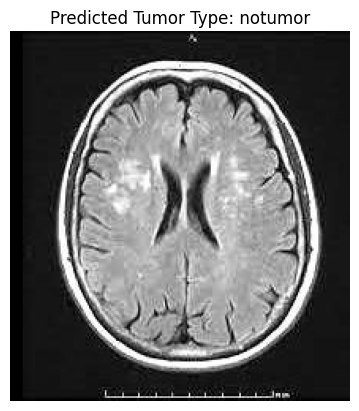

In [ ]:
# Example usage
visualize_prediction(test_df, model, label_mapping, inverse_label_mapping)